In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # removal rate of asymptomatic infectives
gIs   = 1./7            # removal rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

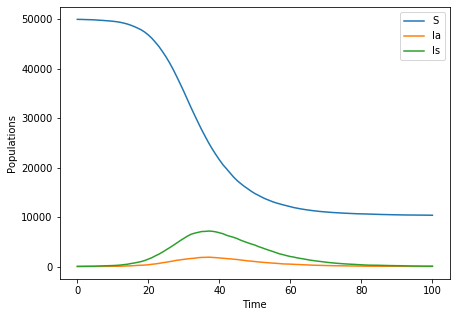

In [4]:
# plot the stochastic solution 
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(np.sum (data_array[:, 0*M:1*M],axis=-1), label='S')
ax.plot(np.sum (data_array[:, 1*M:2*M],axis=-1), label='Ia')
ax.plot(np.sum (data_array[:, 2*M:3*M],axis=-1), label='Is')
ax.set_xlabel('Time')
ax.set_ylabel('Populations')
ax.legend()
plt.show()
plt.close()

# Infer parameters based on part of the trajectory

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 15 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-719.7114137750903
0.1365799903869629


In [9]:
# take a guess 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.1
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.2
beta_std = 0.1 
beta_bounds = (eps, 1)

gIa_g = 0.01
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.01
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds])
keys = ['alpha', 'beta', 'gIa', 'gIs']

start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, contactMatrix, 
                                  global_max_iter=20,
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=1309560084, Tue May 19 14:24:00 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.423362701935852e+02 1.0e+00 1.23e+00  1e-01  2e-01 0:02.8
    2     32 -3.512002277789221e+02 1.6e+00 1.37e+00  1e-01  2e-01 0:04.3
    3     48 -6.248849257759373e+02 1.6e+00 1.61e+00  1e-01  2e-01 0:05.8
    5     80 -5.225718387202827e+02 2.0e+00 1.68e+00  1e-01  3e-01 0:09.3
    7    112 -2.654092223785493e+02 2.8e+00 1.93e+00  1e-01  4e-01 0:13.5
   11    176 -5.143442877838746e+02 4.1e+00 1.58e+00  9e-02  3e-01 0:18.9
   18    288 -6.211704192670567e+02 4.9e+00 9.69e-01  3e-02  1e-01 0:25.3
Optimal value (global minimisation):  -624.8849257759373
Starting local minimisation...
Optimal value (local minimisation):  -702.8998204687374
[1.20651416e-01 2.08430494e-02 1.00000000e-04 1.76394777e-01]
37.1951208114624


In [7]:
hessian = estimator.hessian(params,guess, stds,x,Tf_inference,Nf_inference,contactMatrix)
cov = np.linalg.inv(hessian)
#cov

# Compare forecast based on inferred parameters to full trajectory

In [8]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa,
             'cov':cov}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR(parameters, M, Ni)

In [9]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[-1,:M]*N
Ia0_forecast = x[-1,M:2*M]*N
Is0_forecast = x[-1,2*M:]*N

# Number of simulations over which we average, use 500
Ns = 10 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, Ia0_forecast, Is0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

Finished. Time needed for evaluation: 00:00:06


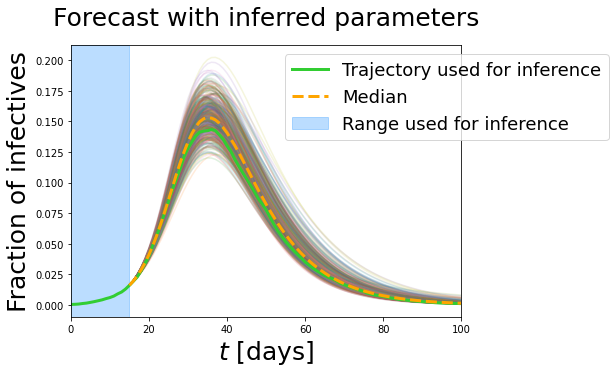

In [10]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = trajectories_forecast[:,4] + trajectories_forecast[:,5]
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = data_array[:,4] + data_array[:,5]

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=18)
plt.show()
plt.close()